In [ ]:
import pandas as pd

df = pd.read_excel('EMCIvsLMCI.xlsx')

print(df.head())

      PID  Patient ID      Sex      Age Report Date  Scale factor      SNR  \
0  2010.0  job1701869  UNKNOWN  UNKNOWN  2024-06-12       0.65914  21.8233   
1  2010.0  job1701872  UNKNOWN  UNKNOWN  2024-06-12       0.62870  16.2326   
2  2010.0  job1701874  UNKNOWN  UNKNOWN  2024-06-12       0.64257  22.4654   
3  2010.0  job1701875  UNKNOWN  UNKNOWN  2024-06-12       0.64244  23.4545   
4  2010.0  job1701879  UNKNOWN  UNKNOWN  2024-06-12       0.63612  21.6140   

      mSNR       QC  Tissue WM cm3  ...  Amygdala Left %  Amygdala Asymmetry  \
0  22.2069  0.95031       386.3687  ...             0.08             2.74740   
1  16.0839  0.94907       366.9233  ...             0.07             5.79610   
2  22.9172  0.95168       371.8851  ...             0.07             5.96480   
3  23.9314  0.95228       366.1105  ...             0.07             4.62800   
4  22.1309  0.95335       366.9811  ...             0.07             0.79566   

   Accumbens Total cm3  Accumbens Total %  Accumbe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Columns: 116 entries, PID to Label
dtypes: datetime64[ns](1), float64(110), int64(1), object(4)
memory usage: 187.7+ KB


In [ ]:
df.isna().sum()

PID                    115
Patient ID               0
Sex                      0
Age                      0
Report Date              0
                      ... 
Accumbens Right %        0
Accumbens Left cm3       0
Accumbens Left %         0
Accumbens Asymmetry      0
Label                    0
Length: 116, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df[['Cerebrum R GM %','Tissue CSF %','Amygdala Total %','Caudate Total %','Accumbens Total %']]
y = df['Label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=62, shuffle=True)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=62)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]


In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 5,
    'lambda': 1.0,
    'alpha': 1.0
}

num_round = 41

bst = xgb.train(params, dtrain, num_round)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import  precision_score, recall_score, f1_score

preds = bst.predict(dtest)

predicted_labels = (preds > 0.5).astype(int)

accuracy = accuracy_score(y_test, predicted_labels)
conf_matrix = confusion_matrix(y_test, predicted_labels)

print('Confusion Matrix:')
print(conf_matrix)

print('Class Labels:')
print(label_encoder.classes_)

accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 score: {f1 * 100:.2f}%")

Confusion Matrix:
[[15  3]
 [ 2 21]]
Class Labels:
['EMCI' 'LMCI']
Accuracy: 87.80%
Precision: 87.50%
Recall: 91.30%
F1 score: 89.36%


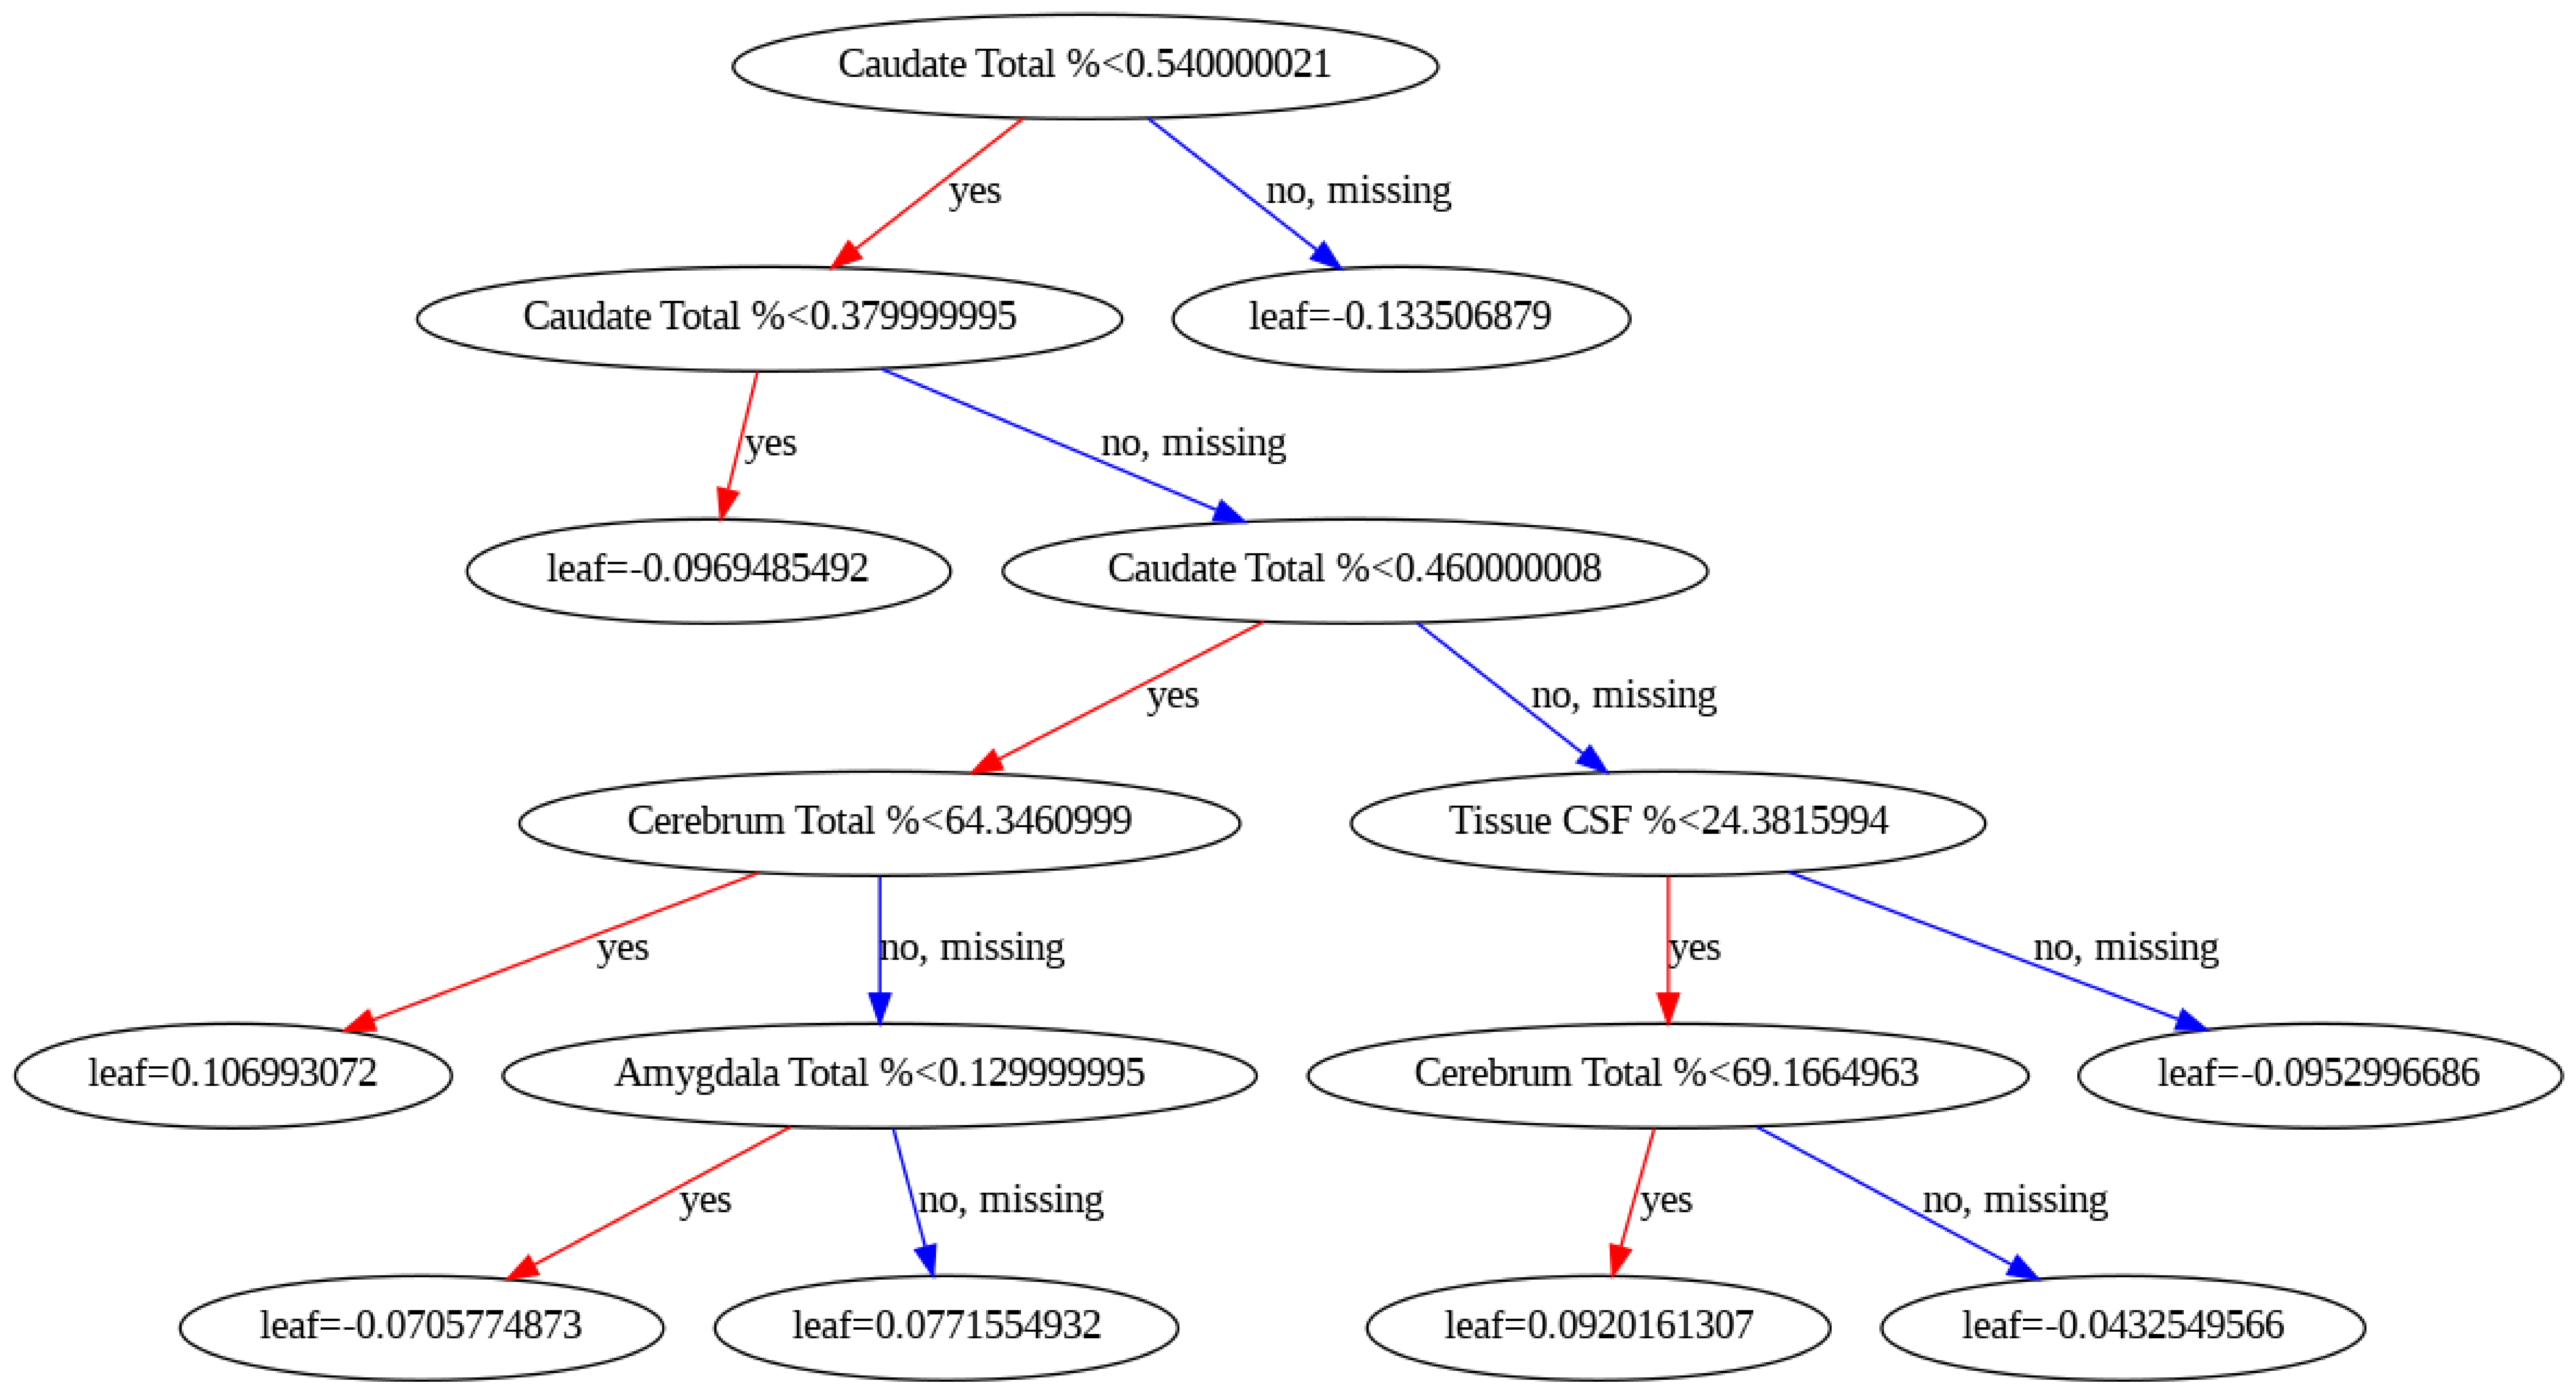

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
xgb_model_reg = bst

tree_index = 0

fig, ax = plt.subplots(figsize=(100, 100))
xgb.plot_tree(xgb_model_reg, num_trees=tree_index, ax=ax)
plt.show()

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import gridsearchcv as gs
# Select features and label
X = df[['Cerebrum Total %', 'Tissue CSF %', 'Amygdala Total %', 'Caudate Total %', 'Accumbens Total %']]
y = df['Label']

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=62)

# Parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 5,
    'lambda': 1.0,
    'alpha': 1.0
}
num_round = 41

# Metrics storage
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Train the model
    bst = xgb.train(params, dtrain, num_round)

    # Make predictions
    preds = bst.predict(dtest)
    predicted_labels = (preds > 0.5).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predicted_labels)
    precision = precision_score(y_test, predicted_labels)
    recall = recall_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)

    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Calculate average metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1_scores)

# Print metrics
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
print(f"Mean Precision: {mean_precision * 100:.2f}%")
print(f"Mean Recall: {mean_recall * 100:.2f}%")
print(f"Mean F1 score: {mean_f1 * 100:.2f}%")


Mean Accuracy: 82.08%
Mean Precision: 81.21%
Mean Recall: 83.62%
Mean F1 score: 81.97%
